<a href="https://colab.research.google.com/github/jiangfz1997/Bitcoin_Price_Prediction/blob/main/notebooks/LSTM_bitcoin_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
drive_base_dir = "/content/drive/MyDrive/Colab_Notebooks/trained_models"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Parameters

In [2]:
import os
window_size = 30
result_file = os.path.join(drive_base_dir, "training_results.csv")
model_path = os.path.join(drive_base_dir, "models")
history_path = os.path.join(drive_base_dir, "histories")

# Function

## Training dataset prepare


In [16]:
# @title
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size][0])
    return np.array(X), np.array(y)
# create sequences for multi-step LSTM
def make_multistep_sequences(data, window_size=30, future_steps=5, index=0):

    X, y = [], []
    for i in range(len(data) - window_size - future_steps + 1):
        X.append(data[i : i + window_size, :])
        y.append(data[i + window_size : i + window_size + future_steps, index])
    return np.array(X), np.array(y)

## Model Training

### evaluate_model

In [27]:
from xml.parsers.expat import model
from matplotlib import units
import numpy as np
import os
import json
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import load_model, Sequential
from keras.layers import Layer, LSTM, Dense, Dropout
import keras.backend as K
from keras.metrics import MeanAbsoluteError
from keras.losses import MeanSquaredError
def evaluate_model(model_path, history_path, X_test, y_test, scaler=None, title=None, attention=None):
    # Load model
    custom_objects = {
        'mae': MeanAbsoluteError(),
    }

    if attention:
        custom_objects['Attention'] = attention
    model = load_model(model_path, custom_objects=custom_objects)

    # Predict
    y_pred = model.predict(X_test)

    if y_test.ndim == 1:
        y_test = y_test[:, None]
        y_pred = y_pred[:, None]
    if scaler:
        min_close, max_close = scaler.data_min_[0], scaler.data_max_[0]
        y_test_plot = y_test * (max_close - min_close) + min_close
        y_pred_plot = y_pred * (max_close - min_close) + min_close
    else:
        y_test_plot = y_test
        y_pred_plot = y_pred

    assert y_test_plot.shape == y_pred_plot.shape
    # Metrics
    mse = mean_squared_error(y_test_plot, y_pred_plot)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_plot, y_pred_plot)
    mape = np.mean(np.abs((y_test_plot - y_pred_plot) / y_test_plot)) * 100
    r2 = r2_score(y_test_plot, y_pred_plot)


    train_loss = val_loss = None
    if history_path:
        with open(history_path, "r") as f:
            history = json.load(f)
        train_loss = history.get("loss", None)
        val_loss = history.get("val_loss", None)


    fig, axes = plt.subplots(3, 1, figsize=(12, 12),
                         gridspec_kw={'height_ratios': [3, 2, 1]})

    # ① Prediction vs True
    axes[0].plot(y_test_plot, label="True", color="blue")
    axes[0].plot(y_pred_plot, label="Predicted", color="orange")
    axes[0].set_title(title or "Prediction vs True")
    axes[0].set_xlabel("Time Step")
    axes[0].set_ylabel("Price" if scaler else "Scaled Value")
    axes[0].legend()
    axes[0].grid(True)

    # ② Loss Curve
    if train_loss and val_loss:
        axes[1].plot(train_loss, label="Train Loss", color="green")
        axes[1].plot(val_loss, label="Validation Loss", color="red")
        axes[1].set_title("Training vs Validation Loss")
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Loss")
        axes[1].legend()
        axes[1].grid(True)
    else:
        axes[1].text(0.5, 0.5, "No loss history found", fontsize=12, ha='center')
    axes[2].axis("off")                           # 关闭坐标轴
    text_str = (
        f"MSE   : {mse:,.2f}\n"
        f"RMSE  : {rmse:,.2f}\n"
        f"MAE   : {mae:,.2f}\n"
        f"MAPE  : {mape:.2f} %\n"
        f"R²    : {r2:.6f}"
    )
    axes[2].text(0.01, 0.9, "Evaluation Metrics", fontsize=14, weight='bold')
    axes[2].text(0.01, 0.5, text_str, fontsize=12, va='top',
                family="monospace")

    plt.tight_layout()
    plt.show()


    return {
        "model": model_path,
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2
    }

def predict_model_multistep(model_path,
              history_path,
              X_test,
              y_test,
              future_steps=1,
              scaler=None,
              title=None,
              attention=None):



    custom_objects = {
        'mae': MeanAbsoluteError(),
    }

    if attention:
        custom_objects['Attention'] = attention
    model = load_model(model_path, custom_objects=custom_objects)


    y_pred  = model.predict(X_test)
    return y_pred

def evaluate(y_test, y_pred, scaler=None, title=None, history_path=None, future_steps=1):
    print("y_pred.shape:", y_pred.shape)
    print("y_true.shape:", y_test.shape)

    def to_2d(a):
        a = np.asarray(a)
        if a.ndim == 3 and a.shape[-1] == 1:  # (N,H,1)->(N,H)
            a = a[..., 0]
        if a.ndim == 1:                       # (N,)->(N,1)
            a = a[:, None]
        assert a.ndim == 2, f"bad shape: {a.shape}"
        return a
    y_test = to_2d(y_test)
    y_pred = to_2d(y_pred)

    if scaler is not None:
        min_close, max_close = scaler.data_min_[0], scaler.data_max_[0]
        y_test_plot = y_test * (max_close - min_close) + min_close
        y_pred_plot = y_pred * (max_close - min_close) + min_close
    else:
        y_test_plot = y_test
        y_pred_plot = y_pred





    Ht, Hp = y_test.shape[1], y_pred.shape[1]
    if Ht != Hp:
        H = min(Ht, Hp)
        print(f"[warn] horizon mismatch: y_true={Ht}, y_pred={Hp} -> using first {H}")
        y_test = y_test[:, :H]
        y_pred = y_pred[:, :H]
    else:
        H = Hp


    mse  = mean_squared_error(y_test, y_pred, multioutput="raw_values")
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test, y_pred, multioutput="raw_values")
    mape = np.mean(np.abs((y_test - y_pred) / y_test), axis=0) * 100
    r2   = [r2_score(y_test[:, k], y_pred[:, k]) for k in range(future_steps)]


    fig, ax = plt.subplots(figsize=(14, 6))
    show_n = min(300, len(y_test_plot))
    for k in range(future_steps):
        ax.plot(y_test_plot[:show_n, k], label=f"True t+{k+1}")
        ax.plot(y_pred_plot[:show_n, k], "--", label=f"Pred t+{k+1}")
    ax.set_title(title or f"Multi-step Forecast (first {show_n} samples)")
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Price" if scaler else "Scaled Value")
    ax.legend(ncol=2); ax.grid(True); plt.show()


    if history_path and os.path.exists(history_path):
        with open(history_path, "r") as f:
            hist = json.load(f)
        if "loss" in hist and "val_loss" in hist:
            plt.figure(figsize=(8, 4))
            plt.plot(hist["loss"],     label="Train Loss")
            plt.plot(hist["val_loss"], label="Val Loss")
            plt.title("Training vs Validation Loss")
            plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True); plt.show()

    print(f"{'Step':>4} | {'MSE':>10} {'RMSE':>10} {'MAE':>10} {'MAPE%':>8} {'R²':>6}")
    for k in range(future_steps):
        print(f"{k+1:>4} | {mse[k]:10.4f} {rmse[k]:10.4f} {mae[k]:10.4f} {mape[k]:8.2f} {r2[k]:6.4f}")

    return {
        "mse":  mse.tolist(),
        "rmse": rmse.tolist(),
        "mae":  mae.tolist(),
        "mape": mape.tolist(),
        "r2":   r2
    }

### train_and_save_model

In [38]:
import os
import json
import csv
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import numpy as np


def train_and_save_model(X_train, y_train,
            X_val, y_val,
            model_index=0,
            layers=1,
            units=64,
            dropout_rate=0.2,
            batch_size=32,
            epochs=40,
            window_size=30,
            future_steps=1,
            optimizer='adam',
            callbacks=None,
            result_file=None,
            attention=None,
            loss_function='mae',
            note=None):
  if callbacks is not None and not isinstance(callbacks, (list, tuple)):
        callbacks = [callbacks]

  model = Sequential()


  if layers >= 1:
      model.add(LSTM(units, return_sequences=(layers > 1 or attention is not None),
                      input_shape=(window_size, X_train.shape[2])))
      if dropout_rate > 0: model.add(Dropout(dropout_rate))

  for _ in range(1, layers-1):
      model.add(LSTM(units, return_sequences=True))
      if dropout_rate > 0: model.add(Dropout(dropout_rate))


  if layers > 1:
      rs = True if attention is not None else False
      model.add(LSTM(units, return_sequences=rs))
      if dropout_rate > 0: model.add(Dropout(dropout_rate))

  if attention is not None:
      model.add(attention)

  model.add(Dense(future_steps))

  model.compile(optimizer=optimizer, loss=loss_function, metrics=['mae'])

  # Train model
  history = model.fit(
      X_train, y_train,
      validation_data=(X_val, y_val),
      epochs=epochs,
      batch_size=batch_size,
      verbose=1,
      callbacks=callbacks
  )

  # Generate file names and paths
  model_name = f"model_{model_index}_layers{layers}_units{units}"
  if note:
      model_name += f"_{note}"
  model_name += ".h5"
  history_name = f"history_{model_index}.json"

  # Define the base directory in Google Drive
  drive_base_dir = "/content/drive/MyDrive/Colab_Notebooks/trained_models" # You can change this to your preferred directory

  model_path = os.path.join(drive_base_dir, "models", model_name)
  history_path = os.path.join(drive_base_dir, "histories", history_name)
  result_path = os.path.join(drive_base_dir, result_file if result_file else "training_results.csv")


  # Ensure folders exist in Google Drive
  os.makedirs(os.path.join(drive_base_dir, "models"), exist_ok=True)
  os.makedirs(os.path.join(drive_base_dir, "histories"), exist_ok=True)


  try:
    # Save model to Google Drive
    model.save(model_path)

    # Save training history to Google Drive
    with open(history_path, "w") as f:
        json.dump(history.history, f)

    # Get best validation loss
    min_val_loss = min(history.history["val_loss"])

    # Write result to CSV in Google Drive
    write_header = not os.path.exists(result_path)

    with open(result_path, "a", newline="") as csvfile:
        writer = csv.writer(csvfile)
        if write_header:
            writer.writerow([
                "index","lstm_units", "num_layers", "dropout", "batch_size", "epochs",
                "optimizer", "model_name", "val_loss", "history_path"
            ])
        writer.writerow([
            model_index,units, layers, dropout_rate, batch_size,
            epochs,  optimizer, model_name, min_val_loss, history_name
        ])

  except Exception as e:
      print("Error during save or logging:", e)
  return model, history

# Data Preprocessing

<Axes: title={'center': 'Bitcoin Close Price'}, xlabel='Timestamp'>

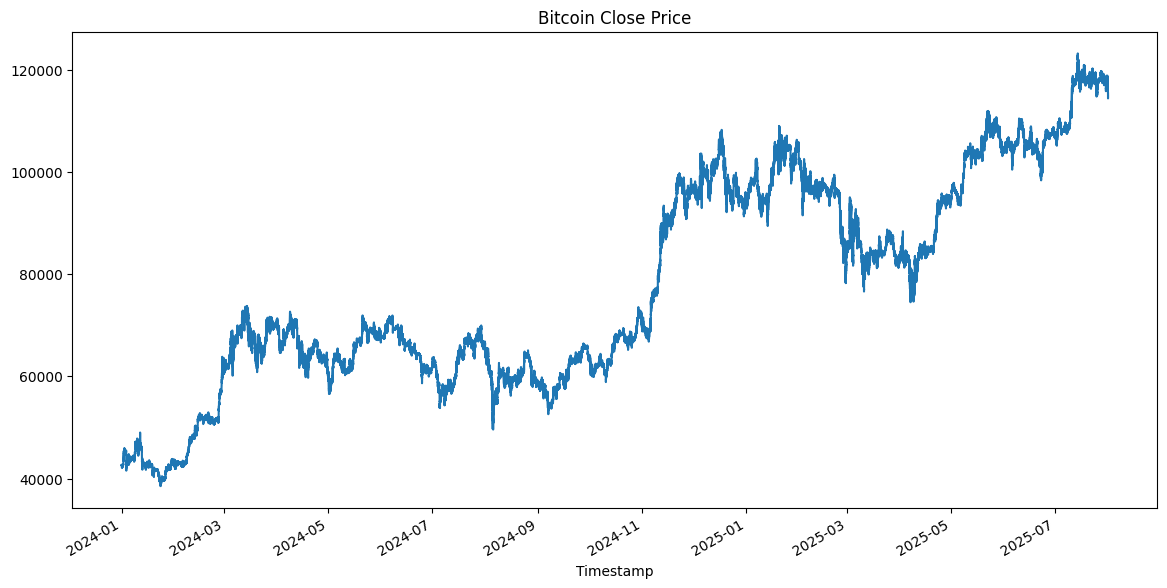

In [6]:
import pandas as pd
from datetime import datetime
import sys
import os

data_path = "/content/drive/MyDrive/btcusd_1-min_data.csv"

bitstamp = pd.read_csv(data_path)
bitstamp['Timestamp'] = pd.to_datetime(bitstamp['Timestamp'], unit='s')
bitstamp.set_index('Timestamp', inplace=True)

bitstamp = bitstamp[(bitstamp.index >= '2024-01-01') & (bitstamp.index <= bitstamp.index[-1])]
bitstamp.Close.plot(figsize=(14,7), title="Bitcoin Close Price")

Missing values in the dataset:
Missing timestamps: 1160
DatetimeIndex(['2025-03-15 00:01:00', '2025-03-15 00:02:00',
               '2025-03-15 00:03:00', '2025-03-15 00:04:00',
               '2025-03-15 00:05:00', '2025-03-15 00:06:00',
               '2025-03-15 00:07:00', '2025-03-15 00:08:00',
               '2025-03-15 00:09:00', '2025-03-15 00:10:00'],
              dtype='datetime64[ns]', freq='min')


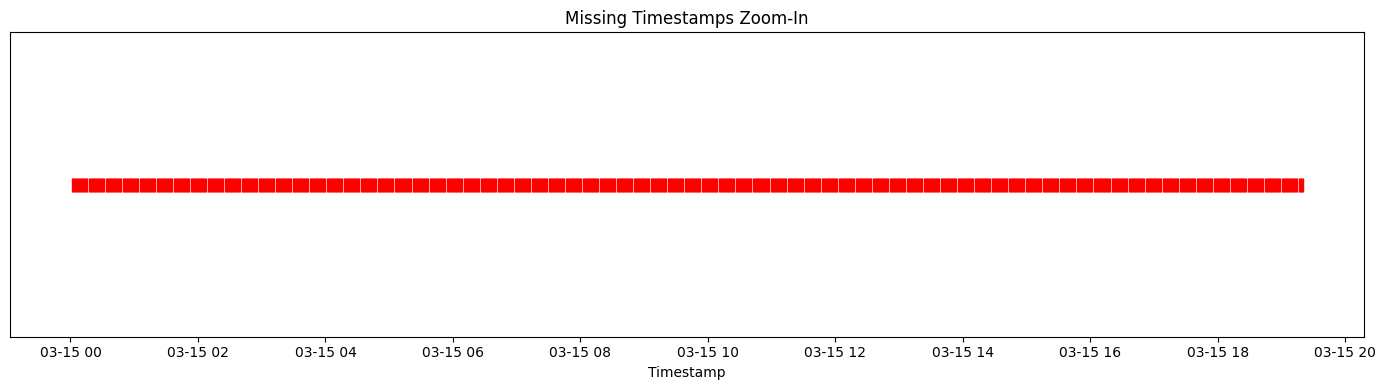

In [7]:
import matplotlib.pyplot as plt

# find missing values by checking for NaN values
missing_values = bitstamp.isnull().sum()
missing_per = (missing_values/bitstamp.shape[0])*100
missing_table = pd.concat([missing_values,missing_per], axis=1, ignore_index=True)
missing_table.rename(columns={0:'Total Missing Values',1:'Missing %'}, inplace=True)
missing_table

# display the missing values
print("Missing values in the dataset:")
expected_range = pd.date_range(start=bitstamp.index.min(), end=bitstamp.index.max(), freq='1min')
missing_times = expected_range.difference(bitstamp.index)
print("Missing timestamps:", len(missing_times))
print(missing_times[:10])

# Plotting the missing timestamps
missing_df = pd.DataFrame(index=missing_times)
missing_df['Missing'] = 1
plt.figure(figsize=(14, 4))
plt.plot(missing_df.index, missing_df['Missing'], '|', color='red', markersize=10)
plt.title("Missing Timestamps Zoom-In")
plt.xlabel("Timestamp")
plt.yticks([])
plt.tight_layout()
plt.show()

/tmp/ipython-input-3003282590.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.fillna(method=method)


Missing values in the dataset:
Missing timestamps: 0
DatetimeIndex([], dtype='datetime64[ns]', freq='min')
                         Open      High       Low     Close    Volume
Timestamp                                                            
2025-08-01 00:55:00  115031.0  115180.0  115031.0  115077.0  4.551279
2025-08-01 00:56:00  115107.0  115258.0  115107.0  115258.0  4.916915
2025-08-01 00:57:00  115258.0  115271.0  115209.0  115271.0  0.950385
2025-08-01 00:58:00  115271.0  115410.0  115271.0  115410.0  5.030814
2025-08-01 00:59:00  115410.0  115464.0  115409.0  115425.0  2.373751


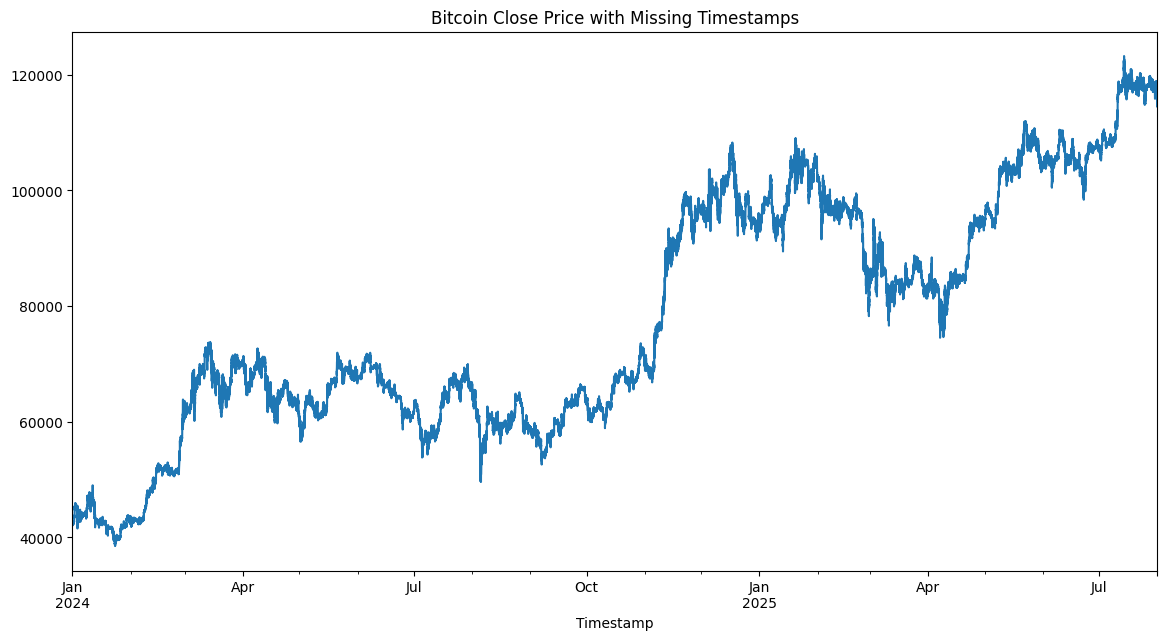

In [8]:
def add_missing_timestamps(df: pd.DataFrame, freq='1min'):
    full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq=freq)
    df_full = df.reindex(full_index)
    df_full.index.name = 'Timestamp'
    return df_full

# Function to fill missing values in the DataFrame using forward fill method.
# This method propagates the last valid observation forward to fill gaps.
def fill_missing_values(df: pd.DataFrame, method='ffill') -> pd.DataFrame:
    return df.fillna(method=method)


bitstamp_full = add_missing_timestamps(bitstamp, freq='1min')
# Plotting the Close price with missing timestamps
bitstamp_full['Close'].plot(figsize=(14, 7), title="Bitcoin Close Price with Missing Timestamps")

# using forward fill to fill the missing values
bitstamp_filled = fill_missing_values(bitstamp_full, method='ffill')

# display the missing values after filling
print("Missing values in the dataset:")
expected_range = pd.date_range(start=bitstamp_filled.index.min(), end=bitstamp_filled.index.max(), freq='1min')
missing_times = expected_range.difference(bitstamp_filled.index)
print("Missing timestamps:", len(missing_times))
print(missing_times[:10])
print(bitstamp_filled.tail())

<Figure size 1200x900 with 0 Axes>

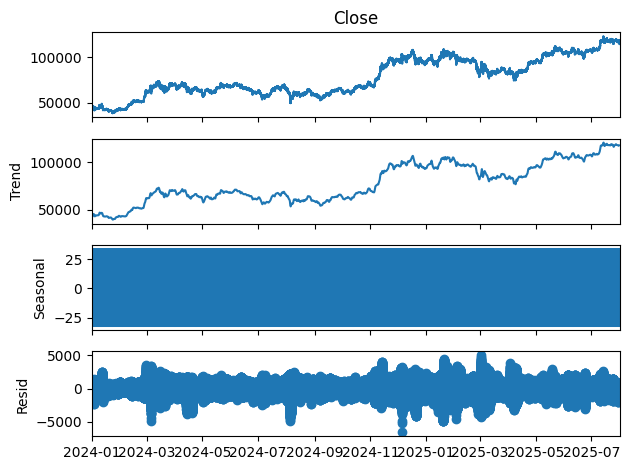

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts = bitstamp_filled['Close'].copy()

ts = ts.resample('1min').mean()

decomp_result = seasonal_decompose(ts, model='additive', period=1440)

trend = decomp_result.trend
seasonal = decomp_result.seasonal
residual = decomp_result.resid

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))
decomp_result.plot()
plt.tight_layout()
plt.show()

# Model Training

## Single-step LSTM Model

### Single step LSTM with simple feature

In [10]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

WINDOW_SIZE = 30
TRAIN_RATIO = 0.8
VAL_RATIO = 0.2

df = bitstamp_filled.copy()
features = df[['Close', 'Volume']].values

n_total = len(features)
n_train = int(n_total * TRAIN_RATIO)

train_features = features[:n_train]
test_features = features[n_train:]

# data
scaler = MinMaxScaler()
scaler.fit(train_features)

scaled_train = scaler.transform(train_features)
scaled_test = scaler.transform(test_features)


X_train_all, y_train_all = create_sequences(scaled_train, WINDOW_SIZE)
X_test, y_test = create_sequences(scaled_test, WINDOW_SIZE)

n_val = int(len(X_train_all) * VAL_RATIO)
X_val = X_train_all[-n_val:]
y_val = y_train_all[-n_val:]
X_train = X_train_all[:-n_val]
y_train = y_train_all[:-n_val]

print("Train scaled range:", X_train_all.min(), X_train_all.max())
print("Test scaled range:", X_test.min(), X_test.max())

Train scaled range: 0.0 1.0
Test scaled range: 0.0 1.2013384754990926


In [12]:
import csv
import json
from keras.callbacks import EarlyStopping
import os

model_index = 1

model, history = train_and_save_model(
    X_train, y_train,
    X_val, y_val,
    model_index=model_index,
    layers=1,
    units=64,
    dropout_rate=0.2,
    batch_size=32,
    epochs=40,
    window_size=window_size,
    callback = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True),
    result_file = result_file,
    note="Single-step_LSTM_with_simple_feature")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
  726/16647 ━━━━━━━━━━━━━━━━━━━━ 5:10 20ms/step - loss: 0.1672

KeyboardInterrupt: 

[0.87664631 0.87661771 0.87697522 ... 1.59313017 1.59511791 1.59533241]


In [23]:
import tensorflow as tf
df = pd.read_csv(result_file)
df.set_index("index", inplace=True)
target_indices = [1]



results = []
for i in target_indices:
    if i not in df.index:
      print(f"index {i} not exist")
      continue
    row = df.loc[i]
    model_file_path = f"{model_path}/{row['model_name']}"
    history_file_path = f"{history_path}/{row['history_path']}"
    print(f"Evaluating {model_file_path} ...")

    # Fix: Add custom_objects to load_model to recognize 'mae'
    result = predict_model_multistep(
        model_path=model_file_path,
        history_path=history_file_path,
        X_test=X_test,
        y_test=y_test,
        scaler=scaler,
        title=f"Model {i} ({row['model_name']})",
        attention=None # Explicitly set attention to None if not used
    )

    results.append(
        {
            "index": i,
            "model_name": row["model_name"],
            "result": result,
            "history": row["history_path"]
        }
      )


Evaluating /content/drive/MyDrive/Colab_Notebooks/trained_models/models/model_1_layers1_units64_Single-step_LSTM_with_simple_feature.h5 ...
5202/5202 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step


y_pred.shape: (166446, 1)
y_true.shape: (166446,)


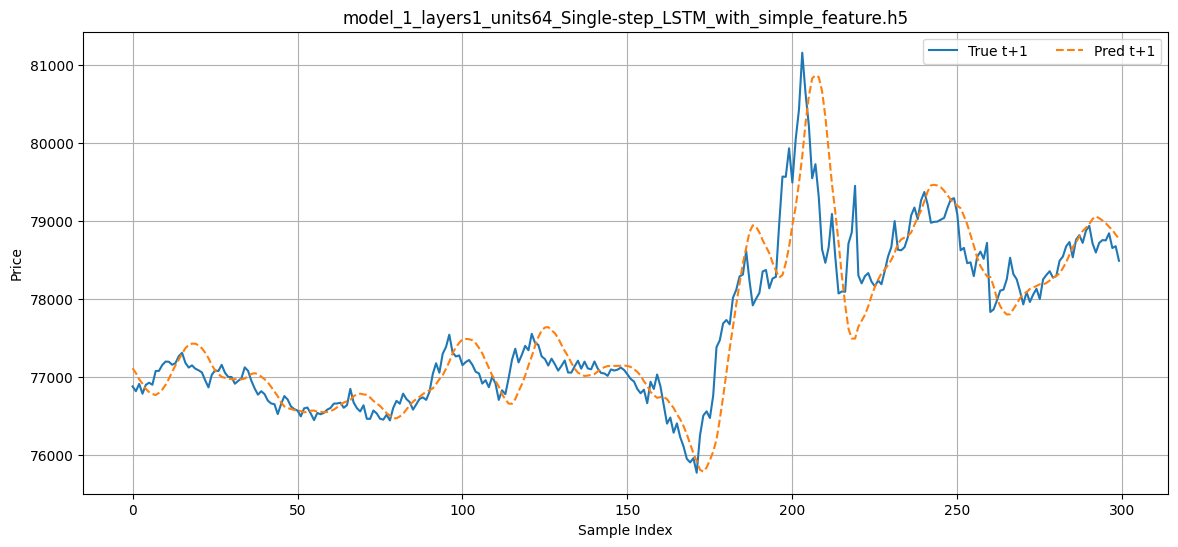

Step |        MSE       RMSE        MAE    MAPE%     R²
   1 |     0.0000     0.0021     0.0016     0.16 0.9998


In [28]:
for r in results:
  evaluate(y_test, r["result"], scaler=scaler, title=r["model_name"], history_path=r["history"])

### Multi-step LSTM with simple feature

In [29]:
df = bitstamp_filled.copy()
df = df[(df.index >= '2024-08-01') & (df.index <= df.index[-1])]

n_total = len(features)
n_train = int(n_total * TRAIN_RATIO)

train_features = features[:n_train]
test_features = features[n_train:]

# data
scaler = MinMaxScaler()
scaler.fit(train_features)

scaled_train = scaler.transform(train_features)
scaled_test = scaler.transform(test_features)


X_train_all, y_train_all = make_multistep_sequences(scaled_train, WINDOW_SIZE, future_steps=5, index=0)
X_test, y_test = make_multistep_sequences(scaled_test, WINDOW_SIZE, future_steps=5, index=0)

n_val = int(len(X_train_all) * VAL_RATIO)
X_val = X_train_all[-n_val:]
y_val = y_train_all[-n_val:]
X_train = X_train_all[:-n_val]
y_train = y_train_all[:-n_val]

print("Train scaled range:", X_train_all.min(), X_train_all.max())
print("Test scaled range:", X_test.min(), X_test.max())

Train scaled range: 0.0 1.0
Test scaled range: 0.0 1.2013384754990926


In [40]:
import csv
import json
from keras.callbacks import EarlyStopping
import os
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)
model_index = 3

model, history = train_and_save_model(
    X_train, y_train,
    X_val, y_val,
    model_index=model_index,
    layers=1,
    units=128,
    dropout_rate=0.2,
    batch_size=64,
    epochs=40,
    window_size=window_size,
    callbacks = [EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True),reduce_lr],
    result_file = result_file,
    note="Multi-step_LSTM_with_simple_feature")

Epoch 1/40
8324/8324 ━━━━━━━━━━━━━━━━━━━━ 491s 57ms/step - loss: 0.0131 - mae: 0.0131 - val_loss: 0.0053 - val_mae: 0.0053 - learning_rate: 0.0010
Epoch 2/40
8324/8324 ━━━━━━━━━━━━━━━━━━━━ 471s 57ms/step - loss: 0.0062 - mae: 0.0062 - val_loss: 0.0028 - val_mae: 0.0028 - learning_rate: 0.0010
Epoch 3/40
8324/8324 ━━━━━━━━━━━━━━━━━━━━ 502s 57ms/step - loss: 0.0060 - mae: 0.0060 - val_loss: 0.0015 - val_mae: 0.0015 - learning_rate: 0.0010
Epoch 4/40
8324/8324 ━━━━━━━━━━━━━━━━━━━━ 472s 57ms/step - loss: 0.0059 - mae: 0.0059 - val_loss: 0.0059 - val_mae: 0.0059 - learning_rate: 0.0010
Epoch 5/40
8324/8324 ━━━━━━━━━━━━━━━━━━━━ 500s 56ms/step - loss: 0.0058 - mae: 0.0058 - val_loss: 0.0116 - val_mae: 0.0116 - learning_rate: 0.0010
Epoch 6/40
8324/8324 ━━━━━━━━━━━━━━━━━━━━ 504s 57ms/step - loss: 0.0057 - mae: 0.0057 - val_loss: 0.0013 - val_mae: 0.0013 - learning_rate: 0.0010
Epoch 7/40
8324/8324 ━━━━━━━━━━━━━━━━━━━━ 504s 57ms/step - loss: 0.0057 - mae: 0.0057 - val_loss: 0.0020 - val_mae: 0.

In [41]:
import tensorflow as tf
df = pd.read_csv(result_file)
df.set_index("index", inplace=True)
target_indices = [3]



results = []
for i in target_indices:
    if i not in df.index:
      print(f"index {i} not exist")
      continue
    row = df.loc[i]
    model_file_path = f"{model_path}/{row['model_name']}"
    history_file_path = f"{history_path}/{row['history_path']}"
    print(f"Evaluating {model_file_path} ...")

    # Fix: Add custom_objects to load_model to recognize 'mae'
    result = predict_model_multistep(
        model_path=model_file_path,
        history_path=history_file_path,
        X_test=X_test,
        y_test=y_test,
        scaler=scaler,
        title=f"Model {i} ({row['model_name']})",
        attention=None # Explicitly set attention to None if not used
    )

    results.append(
        {
            "index": i,
            "model_name": row["model_name"],
            "result": result,
            "history": row["history_path"]
        }
      )


Evaluating /content/drive/MyDrive/Colab_Notebooks/trained_models/models/model_3_layers1_units128_Multi-step_LSTM_with_simple_feature.h5 ...


5202/5202 ━━━━━━━━━━━━━━━━━━━━ 67s 13ms/step
